In [235]:
require(tidyverse)
require(data.table)
require(ggplot2)
require(chromVAR)
require(SummarizedExperiment)
require(RColorBrewer)
require(extrafont)  # fonts 
# https://blog.revolutionanalytics.com/2012/09/how-to-use-your-favorite-fonts-in-r-charts.html
suppressMessages(loadfonts())
require(ggthemes)
# #https://rpubs.com/Koundy/71792 theme_Publication
require(ComplexHeatmap)
cols.hm.avg.tf <- colorRampPalette(c(rgb(249, 249, 212, maxColorValue = 255), rgb(60, 
    181, 195, maxColorValue = 255), rgb(30, 35, 86, maxColorValue = 255)), space = "Lab")

require(ggpubr)

theme_pubr<- function (base_size = 11, base_family = "Arial") 
{
    theme_foundation() + theme(line = element_line(colour = "black", 
        lineend = "round", linetype = "solid"), rect = element_rect(fill = "white", 
        colour = "black", linetype = "solid"), text = element_text(colour = "black", 
        face = "plain", family = base_family, size = base_size, 
        vjust = 0.5, hjust = 0.5, lineheight = 0.5), panel.background = element_blank(), 
        plot.background = element_blank(), panel.border = element_rect(colour = "black", 
            fill = NA), panel.grid = element_blank(), strip.background = element_rect(colour = NA), 
        legend.key = element_rect(colour = NA), title = element_text(size = rel(1)), 
        plot.title = element_text(size = rel(1.2), face = "bold"), 
        strip.text = element_text(), axis.ticks.length = unit(0.5, 
            "lines"))
}

## 1. chromVar

### 1.1 select variable motifs

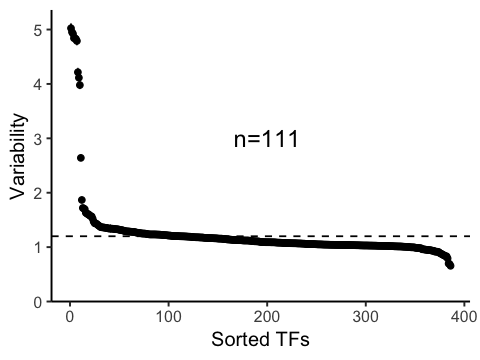

In [72]:
options(repr.plot.width=4, repr.plot.height=3)
variability <- read.csv("../dat/output.jaspar.var.res.csv",row.names=1)
plotVariability(variability, use_plotly = FALSE,labels = "",)+
    geom_hline(yintercept = 1.2,linetype=2)+
    annotate("text",x=200,y=3,
             label=paste0('n=',nrow(subset(variability,variability>=1.2))),
            family = "Arial",size=5)+
theme(text = element_text(family = "Arial"))
ggsave(filename = "fig_s1.select_varible_motifs.pdf",width = 4,height = 3,useDingbats=F)

### 1.2 Select subtype variable motifs

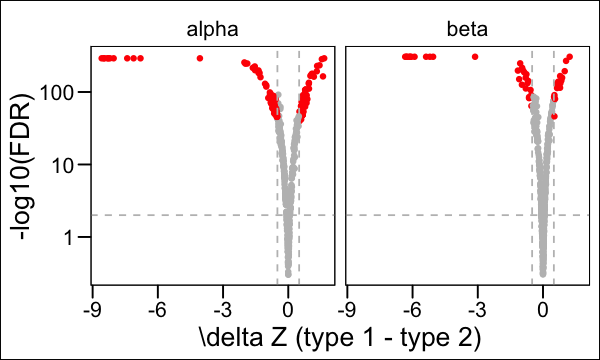

In [74]:
options(repr.plot.width=5, repr.plot.height=3)

ttest.res.pd <- fread("../dat/ttest.res.csv")%>%
  group_by(celltype)%>%
  mutate(min.FDR = min(FDR[FDR!=0]),
         FDR.bak =FDR)%>%
  mutate(FDR=ifelse(FDR==0,min.FDR,FDR))%>%
filter(celltype!="delta")

plt.volcano.ttest <- ggplot(ttest.res.pd,
       aes(delta,-log10(FDR)))+
  geom_point(aes(color=selected),
             shape=ifelse(ttest.res.pd$FDR< ttest.res.pd$min.FDR,17,16))+
  theme_base()+
  geom_hline(yintercept = 2,linetype=2,color='grey')+
  geom_vline(xintercept = c(-.5,.5),linetype=2,color='grey')+
  scale_y_log10()+
  scale_color_manual(values = c("grey","red"))+
  theme(legend.position = "none")+
  facet_wrap(~celltype)+
  xlab("\\delta Z (type 1 - type 2)")

  print(plt.volcano.ttest)
  ggsave(filename ="fig_s2.select_subtype_motifs.pdf",width = 5,height = 3,,useDingbats=F)

### 1.3 plot motif heatmap for alpha and beta cells

quartz_off_screen 
                2

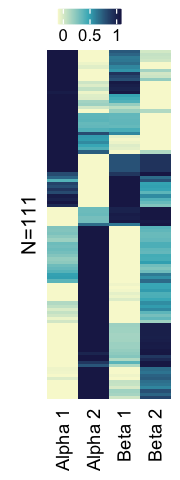

In [137]:
options(repr.plot.width=1.5, repr.plot.height=4)

#calc_varability_heatmap_on_subtypes_ab.R
pd.fig_2B.motif_heatmap_ab <- read.csv("./fig_2B.motif_heatmap_ab.csv",row.names=1)
colnames(pd.fig_2B.motif_heatmap_ab) <- c("Alpha 1","Alpha 2","Beta 1","Beta 2")
ht <- Heatmap(pd.fig_2B.motif_heatmap_ab,
        col=cols.hm.avg.tf(30),cluster_columns = F,cluster_rows = F,
        row_title = paste0("N=",nrow(pd.fig_2B.motif_heatmap_ab)),
        row_title_side ="left",
        row_title_gp = gpar(fontsize = 12),
        show_column_names = T,show_row_names = F,
        column_names_gp = gpar(fontsize = 11),
        name = "",show_heatmap_legend = T,
        heatmap_legend_param = list(at = c(0,0.5,1), 
                                    title_gp = gpar(fontsize = 9),
                                   grid_border="black",
                                    color_bar="continuous",
                                    grid_height = unit(3, "mm"),
                                   legend_direction="horizontal"),
        show_row_dend = F,combined_name_fun = NULL)
draw(ht, heatmap_legend_side = "top")
pdf("fig_2B.motif_heatmap_ab.pdf",height = 4,width = 2,family = "Arial")
draw(ht, heatmap_legend_side = "top")
dev.off()

### 1.4 violin plot for motif (between celltypes)

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”

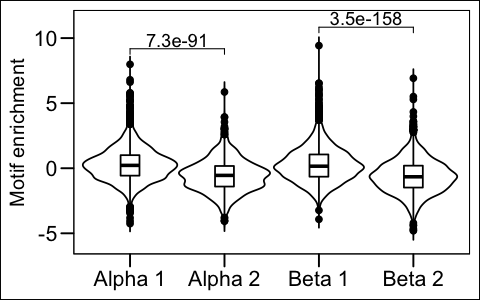

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”

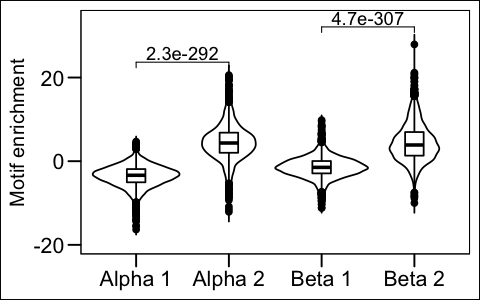

In [216]:
pd.fig_2B.motif_violin_ab <- fread(file = '../figcode/fig_2B.motif_violin_ab.csv')%>%
    mutate(cluster=factor(cluster,levels = c("Alpha 1","Alpha 2","Beta 1", "Beta 2")))

options(repr.plot.width=4, repr.plot.height=2.5)
fun.plotMofifGG <- function(m){
        pd <- pd.fig_2B.motif_violin_ab%>%
                filter(Motif.name==m)
    pd.m <- pd%>%ungroup()%>%
    group_by(cluster)%>%
    summarise(mmin=min(zval),mmax=max(zval))%>%
    as.data.frame()%>%
    column_to_rownames("cluster")
    mmin<- min(pd$zval);mmax<- max(pd$zval)
        ggviolin(pd,
              x = "cluster",y = "zval",add = "boxplot",ylab="Motif enrichment") + 
    theme_base()+ 
    stat_pvalue_manual(data = ttest.res.pd%>%filter(motif==m)%>%
            ungroup()%>%
        mutate(group1=c("Alpha 1","Beta 1"),
          group2=c("Alpha 2","Beta 2"),
        FDR=signif(FDR,2),
        y.position=c(max(pd.m[c("Alpha 1","Alpha 2"),"mmax"])*1.15,
                    max(pd.m[c("Beta 1","Beta 2"),"mmax"])*1.15)), label = "FDR",
        xmin = "group1", xmax = "group2",
        y.position = "y.position")+
    coord_cartesian(expand = T,ylim = c(mmin*1.2,mmax*1.2))+
    theme(legend.position = "none",axis.title.x = element_blank(),
          title = element_text(size = 12,hjust = 0.5),
          text = element_text(family = "Arial"))
}

fun.plotMofifGG("RFX3")
ggsave(filename ="fig_2B.motif_violin_ab_RFX3.pdf",width = 4,height = 2.5,,useDingbats=F)
fun.plotMofifGG("FOS::JUN")
ggsave(filename ="fig_2B.motif_violin_ab_FOS_JUN.pdf",width = 4,height = 2.5,,useDingbats=F)

fun.plotMofifGG("XBP1")
ggsave(filename ="fig_2B.motif_violin_ab_XBP1.pdf",width = 4,height = 2.5,,useDingbats=F)


### 1.5 UMAP scatter

In [ ]:
#project_jaspar_chromVAR_res_to_umap_subcelltype_ab.R
pd.fig2.umap<- fread(file = "../dat/output.umap.ab.filtered.csv")
input.chromVar.res.list <- readRDS(file = "../dat/output.jaspar.dev.res.Rdata")
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z


input.chromVar.jaspar.z.scale <- input.chromVar.jaspar.z
input.chromVar.jaspar.z.scale[input.chromVar.jaspar.z.scale>4] <- 4
input.chromVar.jaspar.z.scale[input.chromVar.jaspar.z.scale< -4] <- -4


In [144]:
fun.plot.project.motif <- function(motif, input.chromVar.z = input.chromVar.jaspar.z.scale, 
    umap.res = pd.fig2.umap, rescale = F, cls = rev(brewer.pal(n = 11, "RdBu")), 
    bks = c(-5, 0, 5)) {
    require(scales)
    
    motif.idx <- grep(motif, rownames(input.chromVar.z))
    if (length(motif.idx) == 0) {
        message(motif, " is not found!")
        return()
    }
    
    motif.z <- input.chromVar.z[motif.idx[1], ]
    if (rescale) {
        sc <- max(abs(quantile(motif.z, probs = c(0.05, 0.95))))
        motif.z[motif.z > sc] <- sc
        motif.z[motif.z < -sc] <- -sc
    }
    
    motif.z <- motif.z %>% as.data.frame() %>% rownames_to_column("barcodes")
    colnames(motif.z)[2] <- "zval"
    
    tmp <- umap.res %>% right_join(motif.z)
    
    p.default.cluster.motif <- ggplot(tmp, aes(UMAP1, UMAP2)) + geom_point(aes(colour = zval), 
        size = 0.2, shape = 16) + ggtitle(rownames(input.chromVar.jaspar.z)[motif.idx]) + 
        scale_color_gradientn(colours = cls, breaks = bks) + theme_base(base_size = 11, 
        base_family = "Arial") + theme(text = element_blank(), 
        axis.ticks = element_blank(), legend.position = c(0.2, 0.9), legend.direction = "horizontal", 
        legend.key.width = unit(2, "mm"), legend.key.height = unit(0.1, "inches"), 
        legend.text = element_text(size = 6), legend.background = element_rect(fill = "transparent", 
            colour = "transparent"),plot.margin=unit(c(1,1,-1,-1), "mm"))
    
    p.default.cluster.motif
}

Joining, by = "barcodes"
Joining, by = "barcodes"
Joining, by = "barcodes"
Warning message:
“Removed 2104 rows containing missing values (geom_point).”Warning message:
“Removed 2104 rows containing missing values (geom_point).”Warning message:
“Removed 2104 rows containing missing values (geom_point).”

Warning message:
“Removed 2104 rows containing missing values (geom_point).”Warning message:
“Removed 2104 rows containing missing values (geom_point).”Warning message:
“Removed 2104 rows containing missing values (geom_point).”

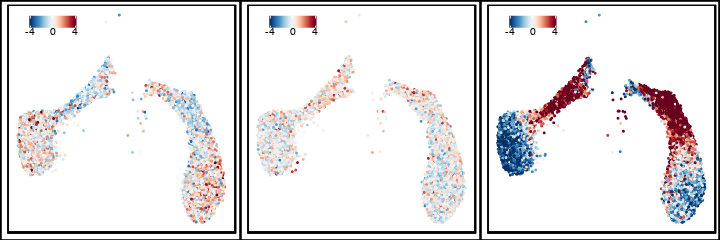

In [145]:
options(repr.plot.width = 6, repr.plot.height = 2)

ps <- lapply(c("RFX3", "XBP1", "FOS::JUN"), fun.plot.project.motif, bks = c(-4, 0, 
    4))
names(ps) <- c("RFX3", "XBP1", "FOS::JUN")
ggarrange(plotlist = ps, ncol = 3)

for (i in names(ps)) ggsave(ps[[i]], filename = paste0("fig_2B.motif_umap_ab_", i, 
    ".pdf"), width = 2, height = 2, , useDingbats = F)

### 1.6 Motif pseduostates

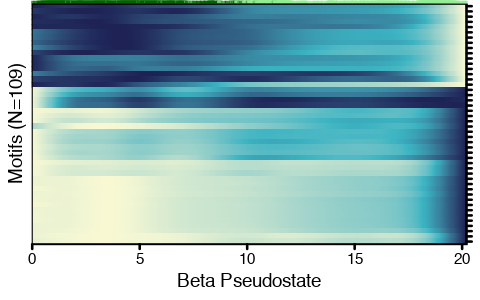

In [262]:
pd.fig_2.motif.beta.pesudostate <- readRDS("../dat/figdata/fig_2.motif.beta.pesudostate.hm.Rds")
l <- length(levels(pd$motif))

pd <- pd.fig_2.motif.beta.pesudostate$pd %>% as.data.frame() %>% rownames_to_column("motif") %>% 
    gather(key = "ps.idx", value = "zval", -1) %>% mutate(ps = (as.numeric(ps.idx) - 
    1) * 0.05, motif = factor(motif, levels = rev(rownames(pd.fig_2.motif.beta.pesudostate$pd)))) %>% 
    select(-ps.idx)


p1 <- ggplot(pd, aes(ps, as.numeric(motif))) + geom_tile(aes(fill = zval)) + theme_pubr() + 
    coord_cartesian(expand = F) + theme(axis.ticks.length = unit(1, "mm"), legend.position = "none", 
    axis.text.y = element_blank(), plot.margin = margin(0.5, 5, 5, 5, "pt")) + scale_fill_gradientn(colours = colorRampPalette(c(rgb(249, 
    249, 212, maxColorValue = 255), rgb(60, 181, 195, maxColorValue = 255), rgb(30, 
    35, 86, maxColorValue = 255)), space = "Lab")(50)) + scale_y_continuous(breaks = c(0, 
    l + 1), sec.axis = sec_axis(~., breaks = 1:l)) + ylab(paste0("Motifs (N=", l, 
    ")")) + xlab("Beta Pseudostate")


p2 <- ggplot(pd.fig_2.motif.beta.pesudostate$pd.anno, aes(pt, 1)) + geom_point(shape = 16, 
    size = 1, aes(color = subtype), alpha = 0.5) + 
    coord_cartesian(expand = F) + theme_void() +ylab("")+ theme(legend.position = "none", 
    plot.margin = margin(0.5, 8, 0, 5, "pt"), axis.title.y = element_text(size = 11, 
        vjust = 1, angle = 90, colour = "black", face = "plain", family = "Arial", 
         hjust = 0.5, lineheight = 0.5)) + scale_color_manual(values = c("darkgreen", 
    "lightgreen"))


options(repr.plot.width = 4, repr.plot.height = 2.5)
ggarrange(p2, p1, nrow = 2, heights = c(1, l))

ggsave( filename = './fig_2B.motif_beta_ps.pdf', width = 4, height = 2.5, useDingbats = F)


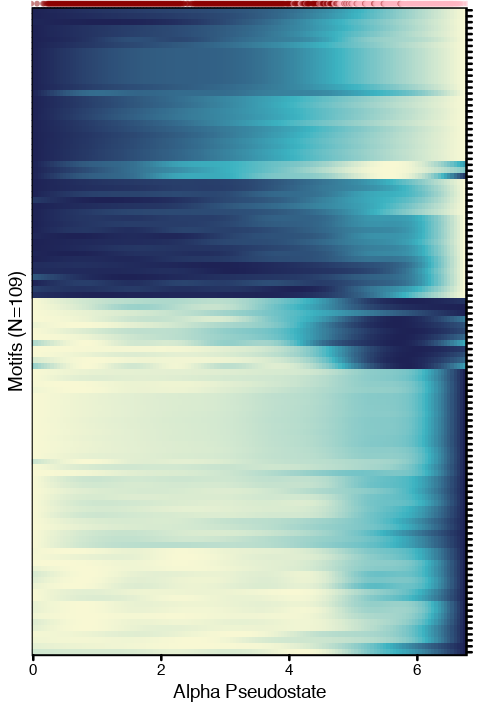

In [263]:
pd.fig_2.motif.alpha.pesudostate <- readRDS("../dat/figdata/fig_2.motif.alpha.pesudostate.hm.Rds")


pd <- pd.fig_2.motif.alpha.pesudostate$pd %>% as.data.frame() %>% rownames_to_column("motif") %>% 
    gather(key = "ps.idx", value = "zval", -1) %>% mutate(ps = (as.numeric(ps.idx) - 
    1) * 0.05, motif = factor(motif, levels = rev(rownames(pd.fig_2.motif.alpha.pesudostate$pd)))) %>% 
    select(-ps.idx)
l <- length(levels(pd$motif))

p1 <- ggplot(pd, aes(ps, as.numeric(motif))) + geom_tile(aes(fill = zval)) + theme_pubr() + 
    coord_cartesian(expand = F) + theme(axis.ticks.length = unit(1, "mm"), legend.position = "none", 
    axis.text.y = element_blank(), plot.margin = margin(0.5, 5, 5, 5, "pt")) + scale_fill_gradientn(colours = colorRampPalette(c(rgb(249, 
    249, 212, maxColorValue = 255), rgb(60, 181, 195, maxColorValue = 255), rgb(30, 
    35, 86, maxColorValue = 255)), space = "Lab")(50)) + scale_y_continuous(breaks = c(0, 
    l + 1), sec.axis = sec_axis(~., breaks = 1:l)) + ylab(paste0("Motifs (N=", l, 
    ")")) + xlab("Alpha Pseudostate")


p2 <- ggplot(pd.fig_2.motif.alpha.pesudostate$pd.anno, aes(pt, 1)) + geom_point(shape = 16, 
    size = 1, aes(color = subtype), alpha = 0.5) + 
    coord_cartesian(expand = F) + theme_void() +ylab("")+ theme(legend.position = "none", 
    plot.margin = margin(0.5, 8, 0, 5, "pt"), axis.title.y = element_text(size = 11, 
        vjust = 1, angle = 90, colour = "black", face = "plain", family = "Arial", 
         hjust = 0.5, lineheight = 0.5)) + scale_color_manual(values = c("darkred", 
    "lightpink"))


options(repr.plot.width = 4, repr.plot.height = 2.5/46*l)
ggarrange(p2, p1, nrow = 2, heights = c(1, l))

ggsave( filename = './fig_2B.motif_alpha_ps.pdf', width = 4, height = 2.5/46*l, useDingbats = F)
